In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [5]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke("what is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]= "true"
os.environ["LANGCHAIN_PROJECT"]= "ReAct-agent"

In [8]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

D:\temp\ipykernel_124292\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [10]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Pulse News Roundup (March 2025 Edition) - Community',
  'url': 'https://community.openai.com/t/ai-pulse-news-roundup-march-2025-edition/1132414',
  'content': 'Tencent open-sourced HunyuanVideo-l2V, an advanced image-to-video AI model featuring custom special effects, audio synchronization, and lip-sync capabilities. The release aims to accelerate creative content production across entertainment and social platforms. (Twitter)\n\nConvergence AI launched Template Hub, a community-powered platform enabling users to build, share, and instantly deploy specialized AI agents. The marketplace aims to democratize AI tools, simplifying deployment for varied tasks and industries. (Twitter) [...] Microsoft is reportedly developing a family of AI models, aiming to rival top competitors like OpenAI and Anthropic. According to sources, recent tests show Microsoft’s models performing competitively against leading products in the market. These models include advanced reasoning capabilit

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [12]:

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_tools(tools)

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is the recent AI News". They likely want a summary of recent AI news. Need up-to-date info. Use search tool (tavily) for recent AI news. Probably fetch top news. Let\'s search.', 'tool_calls': [{'id': 'fc_8ddae41f-43fb-4ece-81fb-ec032da08f0d', 'function': {'arguments': '{"query":"latest AI news 2024 February"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 378, 'total_tokens': 465, 'completion_time': 0.186744881, 'completion_tokens_details': {'reasoning_tokens': 50}, 'prompt_time': 0.018670104, 'prompt_tokens_details': None, 'queue_time': 0.046527997, 'total_time': 0.205414985}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c4bc2-e8f6-7150-885d-1ecb00956473-0', to

In [14]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news February 2026'},
  'id': 'fc_e4410dbe-7aaa-4641-8ac7-c47ba88437e0',
  'type': 'tool_call'}]

In [15]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

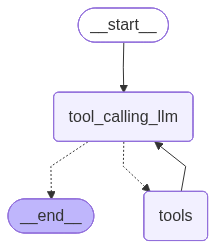

In [16]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news ,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news ,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_d42da2ec-f9ba-4c30-b082-77542020c697)
 Call ID: fc_d42da2ec-f9ba-4c30-b082-77542020c697
  Args:
    query: latest AI news 2024 top 10 recent AI developments February 2026
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Update, February 6, 2026: AI News and Views From the Past Week", "url": "https://www.marketingprofs.com/opinions/2026/54257/ai-update-february-6-2026-ai-news-and-views-from-the-past-week", "content": "Importance for marketers: Competitive advantage now rests on decision velocity and structural redesign. Marketing teams must re-architect workflows, governance, and collaboration models to operationalize AI in real 

In [26]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

**Machine learning (ML)** is a sub‑field of artificial intelligence (AI) that focuses on designing algorithms and statistical models that enable computers to **learn from data** rather than being explicitly programmed for every task. In other words, instead of writing a set of hard‑coded rules, we give a system a large collection of examples (the *training data*) and let it infer the underlying patterns, relationships, or decision boundaries. Once trained, the model can make predictions, classify new inputs, or take actions on data it has never seen before.

---

## Core Concepts

| Concept | What It Means | Typical Example |
|---------|---------------|-----------------|
| **Data** | The raw observations (features) and the desired outputs (labels) that the algorithm uses to learn. | Images of handwri

In [ ]:
##AGENT WITH MEMORY SAVER

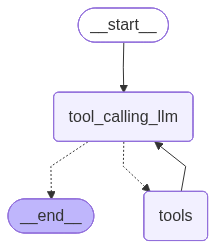

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




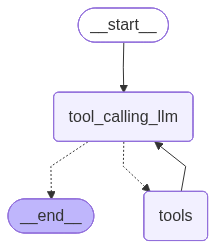

In [21]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory= builder.compile(checkpointer=memory)


display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [22]:
#specify the thread


config={"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Add 12 and 13")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (fc_62f8e746-3aa6-44af-8cbc-d52016691ebe)
 Call ID: fc_62f8e746-3aa6-44af-8cbc-d52016691ebe
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.


In [23]:
messages = [HumanMessage(content="Add 15 to that")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (fc_62f8e746-3aa6-44af-8cbc-d52016691ebe)
 Call ID: fc_62f8e746-3aa6-44af-8cbc-d52016691ebe
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

Add 15 to that
================================== Ai Message ==================================
Tool Calls:
  add (fc_c05ed2d1-a76e-4a3c-9b0b-f4581c36517a)
 Call ID: fc_c05ed2d1-a76e-4a3c-9b0b-f4581c36517a
  Args:
    a: 25
    b: 15
================================= Tool Message =================================
Name: add

40
================================== Ai Message ===================

In [ ]:
def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."